Connecting to MSSQL...
Loaded 27,174 raw rows
Aggregated to D: 7 rows

SALES STATISTICS SUMMARY (BY CATEGORY)
Date Range         : 2022-01-01 to 2022-01-07
Total Revenue      : $8,490,459.08
Total Units Sold   : 2,759,774
Avg Price/Unit     : $3.08
Avg Daily Growth   : +53.28%
Best Category      : Poultry ($1,046,432)
Worst (Rev)        : Costume Jewellery ($0)
Worst (Units)      : Costume Jewellery (0 units)
Best Branch        : MH  Superfresh ($980,705)
Best Department    : Food ($3,120,284)
Best Quarter       : 2022Q1 ($8,490,459)

Top Category by Branch (Top 5):
  • MH  Superfresh: Poultry
  • MH Levuka: Poultry
  • MHCC Level 1 Supermarket: Poultry
  • MHCC Level 2 Homemaker: Small  Kitchen Appliance
  • MHCC Quick Stop: Epay


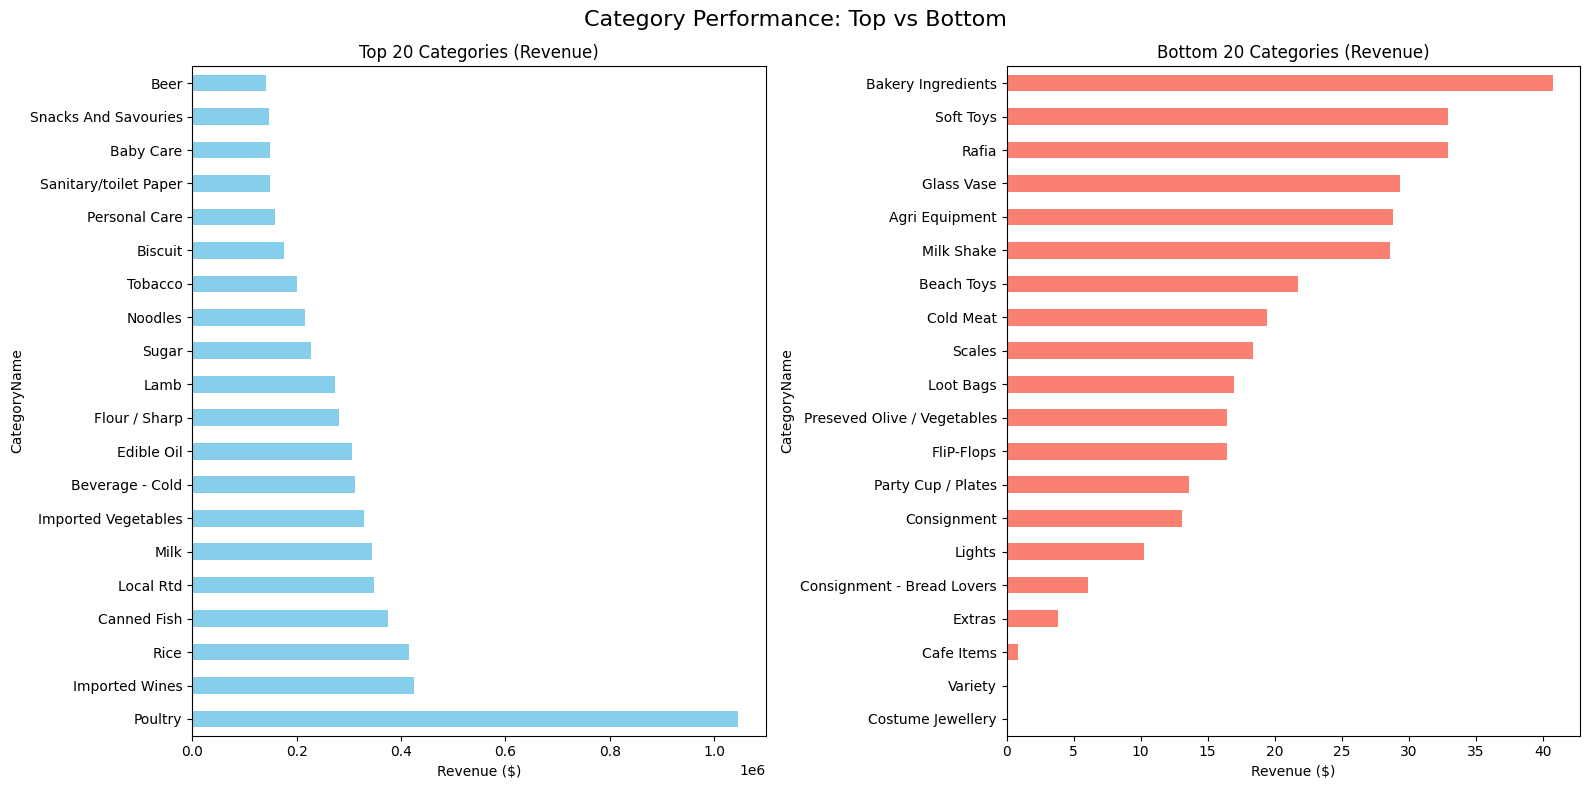

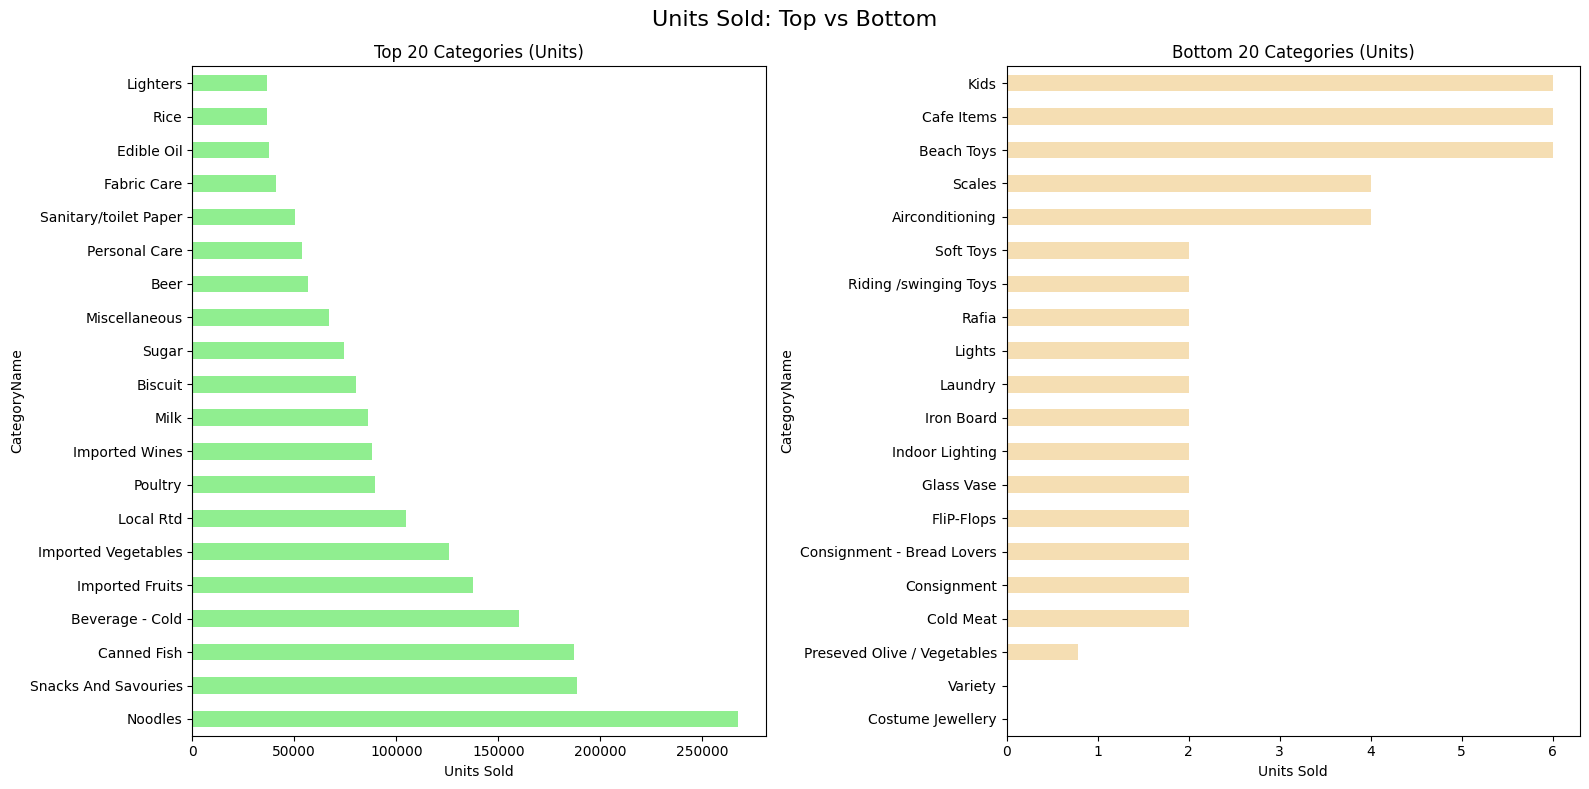

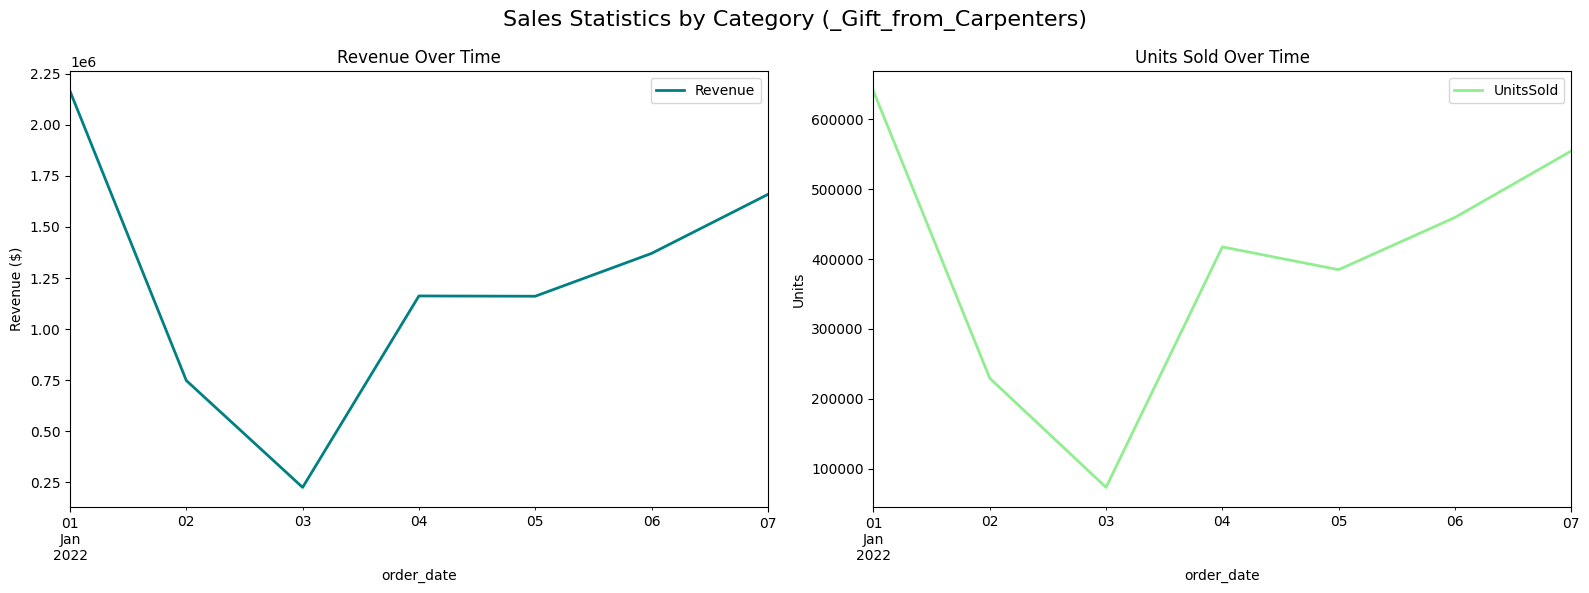

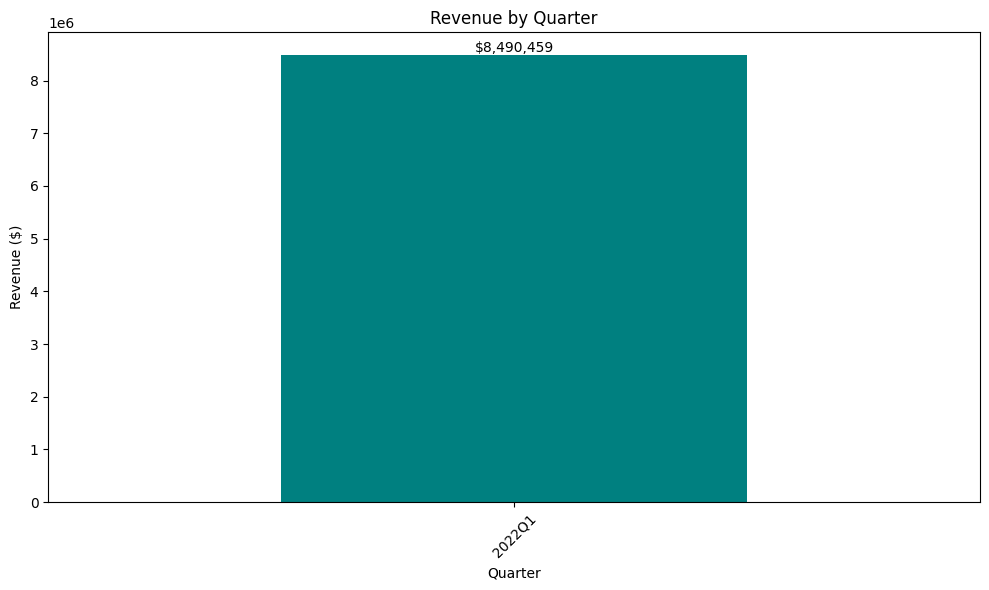

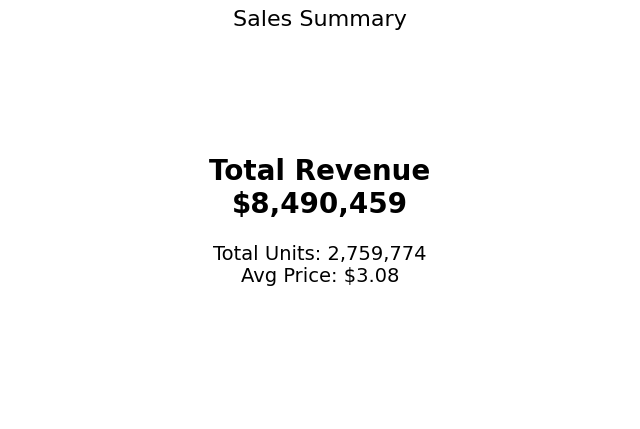

Summary push failed: (pyodbc.ProgrammingError) ('42S22', "[42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'WorstCategoryRev'. (207) (SQLExecDirectW); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'WorstCategoryRevAmt'. (207); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'WorstCategoryUnits'. (207); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'WorstCategoryUnitsAmt'. (207); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Statement(s) could not be prepared. (8180)")
[SQL: INSERT INTO sales_statistics_summary ([RunDate], [TotalRevenue], [TotalUnits], [AvgPricePerUnit], [BestCategory], [BestCategoryRevenue], [WorstCategoryRev], [WorstCategoryRevAmt], [WorstCategoryUnits], [WorstCategoryUnitsAmt], [BestBranch], [BestBranchRevenue], [BestDepartment], [BestDeptRevenue], [BestQuarter], [BestQuarterRevenue]) VALUES (?, ?, ?, ?, ?, ?, ?, ?

In [ ]:
# ================================
# SALES STATISTICS FROM MSSQL (NO ITEM NAME)
# Uses: Branch, Department, Category, Qty, NetSales, Date
# NOW WITH: Worst sellers + Top 20 pushed to SQL
# ================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sqlalchemy import create_engine
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# CONFIGURATION
# -----------------------------
CONFIG = {
    'sql_query': """
        SELECT 
            TranDate_DDMMYYYY AS order_date,
            BranchName,
            DeptName AS DepartmentName,
            CategoryName,
            Qty AS UnitsSold,
            NetSales AS Revenue
        FROM _Gift_from_Carpenters 
        WHERE NetSales IS NOT NULL
        AND TranDate_DDMMYYYY IS NOT NULL
    """,
    'server': '100.99.225.51',
    'database': 'TEST1',
    'username': 'SA',
    'password': 'a31536000',
    'driver': '{ODBC Driver 17 for SQL Server}',
    'encrypt': 'yes',
    'trust_server_certificate': 'yes',
    'connection_timeout': 120,
    'aggregation_freq': 'D',  # D, W, M
    'top_n': 20,
    'target_table': 'sales_statistics_summary',
    'rankings_table': 'category_rankings',  # NEW: Top 20 categories
    'plot_title': 'Sales Statistics by Category (_Gift_from_Carpenters)',
}

FREQ_MAP = {'D': 'D', 'W': 'W-MON', 'M': 'MS'}

# -----------------------------
# 1. LOAD FROM MSSQL
# -----------------------------
def load_data(config):
    conn_str = (
        f"DRIVER={config['driver']};"
        f"SERVER={config['server']};"
        f"DATABASE={config['database']};"
        f"UID={config['username']};"
        f"PWD={config['password']};"
        f"Encrypt={config['encrypt']};"
        f"TrustServerCertificate={config['trust_server_certificate']};"
        f"Connection Timeout={config['connection_timeout']};"
    )
    try:
        print("Connecting to MSSQL...")
        conn = pyodbc.connect(conn_str, timeout=config['connection_timeout'])
        df = pd.read_sql(config['sql_query'], conn)
        conn.close()
        print(f"Loaded {len(df):,} raw rows")

        # Clean & parse
        df['order_date'] = pd.to_datetime(df['order_date'], format='%d/%m/%Y', errors='coerce')
        df['UnitsSold'] = pd.to_numeric(df['UnitsSold'], errors='coerce')
        df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
        df = df.dropna(subset=['order_date', 'UnitsSold', 'Revenue', 'CategoryName'])

        # Aggregate by date
        freq = FREQ_MAP[config['aggregation_freq']]
        df_agg = df.groupby(pd.Grouper(key='order_date', freq=freq)).agg(
            UnitsSold=('UnitsSold', 'sum'),
            Revenue=('Revenue', 'sum')
        ).reset_index()

        # Detail for category/branch/dept analysis
        df_detail = df.groupby(['order_date', 'BranchName', 'DepartmentName', 'CategoryName']).agg(
            UnitsSold=('UnitsSold', 'sum'),
            Revenue=('Revenue', 'sum')
        ).reset_index()

        print(f"Aggregated to {config['aggregation_freq']}: {len(df_agg):,} rows")
        return df_agg, df_detail
    except Exception as e:
        print(f"DB Load Failed: {e}")
        return None, None

# -----------------------------
# 2. COMPUTE STATISTICS (ENHANCED)
# -----------------------------
def compute_statistics(df_agg, df_detail, config):
    stats = {}

    # Total
    stats['total_revenue'] = df_agg['Revenue'].sum()
    stats['total_units'] = df_agg['UnitsSold'].sum()
    stats['avg_price_per_unit'] = stats['total_revenue'] / stats['total_units']

    # Time range
    stats['start_date'] = df_agg['order_date'].min().strftime('%Y-%m-%d')
    stats['end_date'] = df_agg['order_date'].max().strftime('%Y-%m-%d')

    # Category-level aggregates
    cat_agg = df_detail.groupby('CategoryName').agg(
        TotalRevenue=('Revenue', 'sum'),
        TotalUnits=('UnitsSold', 'sum')
    ).reset_index()

    # Top & Bottom by Revenue
    top_rev = cat_agg.nlargest(config['top_n'], 'TotalRevenue')
    bottom_rev = cat_agg.nsmallest(config['top_n'], 'TotalRevenue')
    # Top & Bottom by Units
    top_units = cat_agg.nlargest(config['top_n'], 'TotalUnits')
    bottom_units = cat_agg.nsmallest(config['top_n'], 'TotalUnits')

    stats['best_category'] = top_rev.iloc[0]['CategoryName'] if not top_rev.empty else None
    stats['best_category_revenue'] = top_rev.iloc[0]['TotalRevenue'] if not top_rev.empty else 0
    stats['worst_category_rev'] = bottom_rev.iloc[0]['CategoryName'] if not bottom_rev.empty else None
    stats['worst_category_rev_amt'] = bottom_rev.iloc[0]['TotalRevenue'] if not bottom_rev.empty else 0
    stats['worst_category_units'] = bottom_units.iloc[0]['CategoryName'] if not bottom_units.empty else None
    stats['worst_category_units_amt'] = bottom_units.iloc[0]['TotalUnits'] if not bottom_units.empty else 0

    # Top performers (branches/depts)
    top_branches = df_detail.groupby('BranchName')['Revenue'].sum().nlargest(config['top_n'])
    top_depts = df_detail.groupby('DepartmentName')['Revenue'].sum().nlargest(config['top_n'])

    stats['best_branch'] = top_branches.index[0] if not top_branches.empty else None
    stats['best_branch_revenue'] = top_branches.iloc[0] if not top_branches.empty else 0
    stats['best_department'] = top_depts.index[0] if not top_depts.empty else None
    stats['best_dept_revenue'] = top_depts.iloc[0] if not top_depts.empty else 0

    # Growth
    df_agg['Revenue_Prev'] = df_agg['Revenue'].shift(1)
    df_agg['Growth_%'] = ((df_agg['Revenue'] - df_agg['Revenue_Prev']) / df_agg['Revenue_Prev'].replace(0, np.nan)) * 100
    stats['avg_daily_growth_%'] = df_agg['Growth_%'].mean(skipna=True)

    # Quarterly
    df_q = df_agg.copy()
    df_q['Quarter'] = df_q['order_date'].dt.to_period('Q').astype(str)
    quarterly = df_q.groupby('Quarter')['Revenue'].sum()
    stats['best_quarter'] = quarterly.idxmax() if not quarterly.empty else None
    stats['best_quarter_revenue'] = quarterly.max() if not quarterly.empty else 0

    # Top category per branch
    top_cat_per_branch = df_detail.groupby(['BranchName', 'CategoryName'])['Revenue'].sum().groupby('BranchName').idxmax()
    stats['top_category_by_branch'] = {branch: cat[1] for branch, cat in top_cat_per_branch.items()}

    # === NEW: Rankings for SQL ===
    rankings = top_rev[['CategoryName', 'TotalRevenue', 'TotalUnits']].copy()
    rankings['Rank'] = range(1, len(rankings) + 1)
    rankings['RunDate'] = datetime.now()
    stats['top_20_categories'] = rankings

    return stats, df_agg, df_detail

# -----------------------------
# 3. PLOT STATISTICS (NOW SHOWS TOP & BOTTOM)
# -----------------------------
def plot_statistics(df_agg, df_detail, stats, config):
    plt.style.use('default')
    sns.set_palette("husl")

    # === 1. Top & Bottom Categories (Revenue) ===
    cat_agg = df_detail.groupby('CategoryName')['Revenue'].sum()
    top_cat = cat_agg.nlargest(config['top_n'])
    bottom_cat = cat_agg.nsmallest(config['top_n'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    top_cat.plot(kind='barh', ax=ax1, color='skyblue')
    ax1.set_title(f'Top {config["top_n"]} Categories (Revenue)')
    ax1.set_xlabel('Revenue ($)')
    bottom_cat.plot(kind='barh', ax=ax2, color='salmon')
    ax2.set_title(f'Bottom {config["top_n"]} Categories (Revenue)')
    ax2.set_xlabel('Revenue ($)')
    plt.suptitle("Category Performance: Top vs Bottom", fontsize=16)
    plt.tight_layout()
    plt.savefig("category_top_bottom.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === 2. Top & Bottom Units Sold ===
    cat_units = df_detail.groupby('CategoryName')['UnitsSold'].sum()
    top_u = cat_units.nlargest(config['top_n'])
    bottom_u = cat_units.nsmallest(config['top_n'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    top_u.plot(kind='barh', ax=ax1, color='lightgreen')
    ax1.set_title(f'Top {config["top_n"]} Categories (Units)')
    ax1.set_xlabel('Units Sold')
    bottom_u.plot(kind='barh', ax=ax2, color='wheat')
    ax2.set_title(f'Bottom {config["top_n"]} Categories (Units)')
    ax2.set_xlabel('Units Sold')
    plt.suptitle("Units Sold: Top vs Bottom", fontsize=16)
    plt.tight_layout()
    plt.savefig("units_top_bottom.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === 3. Trends ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    df_agg.plot(x='order_date', y='Revenue', ax=ax1, color='teal', linewidth=2)
    ax1.set_title('Revenue Over Time')
    ax1.set_ylabel('Revenue ($)')
    df_agg.plot(x='order_date', y='UnitsSold', ax=ax2, color='lightgreen', linewidth=2)
    ax2.set_title('Units Sold Over Time')
    ax2.set_ylabel('Units')
    plt.suptitle(config['plot_title'], fontsize=16)
    plt.tight_layout()
    plt.savefig("trends.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === 4. Quarterly ===
    df_q = df_agg.copy()
    df_q['Quarter'] = df_q['order_date'].dt.to_period('Q').astype(str)
    quarterly = df_q.groupby('Quarter')['Revenue'].sum()

    plt.figure(figsize=(10, 6))
    quarterly.plot(kind='bar', color='teal')
    plt.title('Revenue by Quarter')
    plt.ylabel('Revenue ($)')
    plt.xticks(rotation=45)
    for i, v in enumerate(quarterly):
        plt.text(i, v, f"${v:,.0f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig("quarterly_revenue.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === 5. Summary Card ===
    plt.figure(figsize=(8, 5))
    plt.text(0.5, 0.6, f"Total Revenue\n${stats['total_revenue']:,.0f}", 
             ha='center', va='center', fontsize=20, fontweight='bold')
    plt.text(0.5, 0.4, f"Total Units: {stats['total_units']:,.0f}\nAvg Price: ${stats['avg_price_per_unit']:,.2f}", 
             ha='center', va='center', fontsize=14)
    plt.title("Sales Summary", fontsize=16)
    plt.axis('off')
    plt.savefig("sales_summary_card.png", dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------
# 4. PRINT SUMMARY (NOW WITH WORST)
# -----------------------------
def print_statistics(stats):
    print("\n" + "="*75)
    print("SALES STATISTICS SUMMARY (BY CATEGORY)")
    print("="*75)
    print(f"Date Range         : {stats['start_date']} to {stats['end_date']}")
    print(f"Total Revenue      : ${stats['total_revenue']:,.2f}")
    print(f"Total Units Sold   : {stats['total_units']:,.0f}")
    print(f"Avg Price/Unit     : ${stats['avg_price_per_unit']:,.2f}")
    print(f"Avg Daily Growth   : {stats['avg_daily_growth_%']:+.2f}%")
    if stats['best_category']:
        print(f"Best Category      : {stats['best_category']} (${stats['best_category_revenue']:,.0f})")
        print(f"Worst (Rev)        : {stats['worst_category_rev']} (${stats['worst_category_rev_amt']:,.0f})")
        print(f"Worst (Units)      : {stats['worst_category_units']} ({stats['worst_category_units_amt']:,.0f} units)")
    if stats['best_branch']:
        print(f"Best Branch        : {stats['best_branch']} (${stats['best_branch_revenue']:,.0f})")
    if stats['best_department']:
        print(f"Best Department    : {stats['best_department']} (${stats['best_dept_revenue']:,.0f})")
    if stats['best_quarter']:
        print(f"Best Quarter       : {stats['best_quarter']} (${stats['best_quarter_revenue']:,.0f})")
    print("\nTop Category by Branch (Top 5):")
    for branch, cat in list(stats['top_category_by_branch'].items())[:5]:
        print(f"  • {branch}: {cat}")
    print("="*75)

# -----------------------------
# 5. PUSH TO SQL (NOW WITH TOP 20 RANKINGS)
# -----------------------------
def push_to_sql(stats, config):
    engine = create_engine(
        f"mssql+pyodbc://{config['username']}:{config['password']}@"
        f"{config['server']}/{config['database']}?"
        f"driver=ODBC+Driver+17+for+SQL+Server&Encrypt=yes&TrustServerCertificate=yes"
    )

    # 1. Summary
    summary_df = pd.DataFrame([{
        'RunDate': datetime.now(),
        'TotalRevenue': stats['total_revenue'],
        'TotalUnits': stats['total_units'],
        'AvgPricePerUnit': stats['avg_price_per_unit'],
        'BestCategory': stats['best_category'],
        'BestCategoryRevenue': stats['best_category_revenue'],
        'WorstCategoryRev': stats['worst_category_rev'],
        'WorstCategoryRevAmt': stats['worst_category_rev_amt'],
        'WorstCategoryUnits': stats['worst_category_units'],
        'WorstCategoryUnitsAmt': stats['worst_category_units_amt'],
        'BestBranch': stats['best_branch'],
        'BestBranchRevenue': stats['best_branch_revenue'],
        'BestDepartment': stats['best_department'],
        'BestDeptRevenue': stats['best_dept_revenue'],
        'BestQuarter': stats['best_quarter'],
        'BestQuarterRevenue': stats['best_quarter_revenue'],
    }]).fillna('')

    try:
        summary_df.to_sql(config['target_table'], engine, if_exists='append', index=False)
        print(f"Summary pushed to: {config['target_table']}")
    except Exception as e:
        print(f"Summary push failed: {e}")

    # 2. Top 20 Categories
    if 'top_20_categories' in stats:
        rankings_df = stats['top_20_categories'].copy()
        try:
            rankings_df.to_sql(config['rankings_table'], engine, if_exists='replace', index=False)
            print(f"Top 20 categories pushed to: {config['rankings_table']}")
        except Exception as e:
            print(f"Rankings push failed: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    df_agg, df_detail = load_data(CONFIG)
    if df_agg is None:
        return

    stats, df_agg, df_detail = compute_statistics(df_agg, df_detail, CONFIG)
    print_statistics(stats)
    plot_statistics(df_agg, df_detail, stats, CONFIG)
    push_to_sql(stats, CONFIG)
    print("All done. Check PNG files and SQL tables.")

if __name__ == "__main__":
    main()